# Exploring singlepoint

In [6]:
# improts
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path
from glob import glob
import pickle
import shutil
import json
import io
import pandas as pd
import seaborn as sns
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
from rdkit.Chem.rdMolDescriptors import CalcNumRotatableBonds
import py3Dmol


# For highlight colors
from matplotlib.colors import ColorConverter

from ipywidgets import interact,fixed,IntSlider


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Utility functions from nitrogenase module
sys.path.insert(0, '/home/magstr/Documents/nitrogenase/niflheim_scripts/nitrogenase/backup_plot_diagram')
from data_handler import get_energies, get_paths, get_energy_dicts, read_properties_sp
from data_handler import renamed_load, extract_scoring3,extract_scoring2, extract_scoring1
    
# Custom functions 
from my_utils.analysis import draw_generation,conf_viewer, natural_keys, atoi
from my_utils.classes import Generation, Conformers

#IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 500,500
IPythonConsole.drawOptions.addAtomIndices = True

font = {'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)


dft_base = Path('/home/magstr/dft_data')

HARTREE2EV = 27.2114
HARTREE2KCAL = 627.51
kcal = 627.51
ev = 27.2114

In [7]:
# Scoring function dict
funcs = {
        "rdkit_embed_scoring": extract_scoring1,
        "rdkit_embed_scoring_NH3toN2": extract_scoring2,
        "rdkit_embed_scoring_NH3plustoNH3": extract_scoring3,
    }

## Load the reference energies

In [8]:
(
        reactions_gfn1_corrected,
        reactions_gfn2_corrected,
        reactions_dft_ams_tzp,
        reactions_dft_orca_tzp,
        reactions_dft_orca_svp_tzp,
        reactions_dft_orca_sarcJ_tzp
    ) = get_energy_dicts()

In [9]:
reactions_dft_orca_sarcJ_tzp

{'N2': -68745.84023173494,
 'LuH+': -205372.22587124197,
 'Lu': -205110.28921852674,
 'H2': -731.7124100077522,
 'CrCp2+': -1150965.872722023,
 'NH3': -35493.47005100311,
 'CrCp2': -1151064.3911246804,
 'delta_Cp': 98.5184026574716,
 'delta_Lu': 261.9366527152306}

In [10]:
reactions_dft_orca_tzp

{'N2': -68745.86604206839,
 'LuH+': -205372.4092126641,
 'Lu': -205110.45920451736,
 'H2': -731.7751548361912,
 'CrCp2+': -1150967.7260743862,
 'NH3': -35493.542519196264,
 'CrCp2': -1151066.3300395126,
 'delta_Cp': 98.60396512644365,
 'delta_Lu': 261.95000814672676}

In [11]:
reference_dft_scoring_values = {'NH3_toN2': 18.849,'NH3+toNH3': 8.761195885483176,'NH3toNH3_N2': 10.715871259570122}

In [12]:
# Here i hardtested the discrepancy in the two basis sets. 

N2=-5361.363
NH3=-5308.333
print(f'Without def2/j: Delta = {N2*kcal + reactions_dft_orca_sarcJ_tzp["NH3"] - (NH3*kcal + reactions_dft_orca_sarcJ_tzp["N2"])}')
      
N2=-5525.381
NH3=-5472.404
print(f'With def2/j: Delta = {N2*kcal + reactions_dft_orca_tzp["NH3"] - (NH3*kcal + reactions_dft_orca_tzp["N2"])}')
      

Without def2/j: Delta = -24.48511926876381
With def2/j: Delta = 8.72625287156552


# Singlepoint from GA analysis (before ind was saved)

# Singlepoint from GA analysis multiple

In [9]:
# Reference paths: 
# For comparing the dej2 and nodef2 results
# Path('/home/magstr/dft_data/prod_new12_0_def2j'),Path('/home/magstr/dft_data/prod_new12_0')

In [9]:
logfiles = [dft_base/'prod_new22_large_0_long_def2j']
#logfiles = [dft_base / 'prod_new26_2score_large_0',dft_base / 'prod_new26_2score_large_0']

Scoring used: rdkit_embed_scoring_NH3toN2
deltas for f1:[3.3141008345410228, -4.711787006352097, 9.104844246990979, -28.841123329941183, -5.966932717245072, -5.805931266862899, 5.679448970127851, -5.9611720610409975, -3.373858730774373, -17.49469789257273, -5.755412267521024, 0, 0, 33.19234270276502, 10.405717949848622, 16.73112720809877, -4.962110901251435, 0, 0, -7.298415413592011, -1.6767917852848768, 0, -8.12118317000568, 0, 0, 10.205123881809413, 0, -11.914275480434299, -1.2677111942321062, 0, 0, 0, 0, -13.675899446941912, 0, -7.63017287151888, 0, -4.804398565553129, -4.486611002590507, 36.546555378474295, 0, -5.7474280670285225, 0, 0, 0, -5.233628566376865, 0, -8.268594251014292, -6.836927267257124, 0]


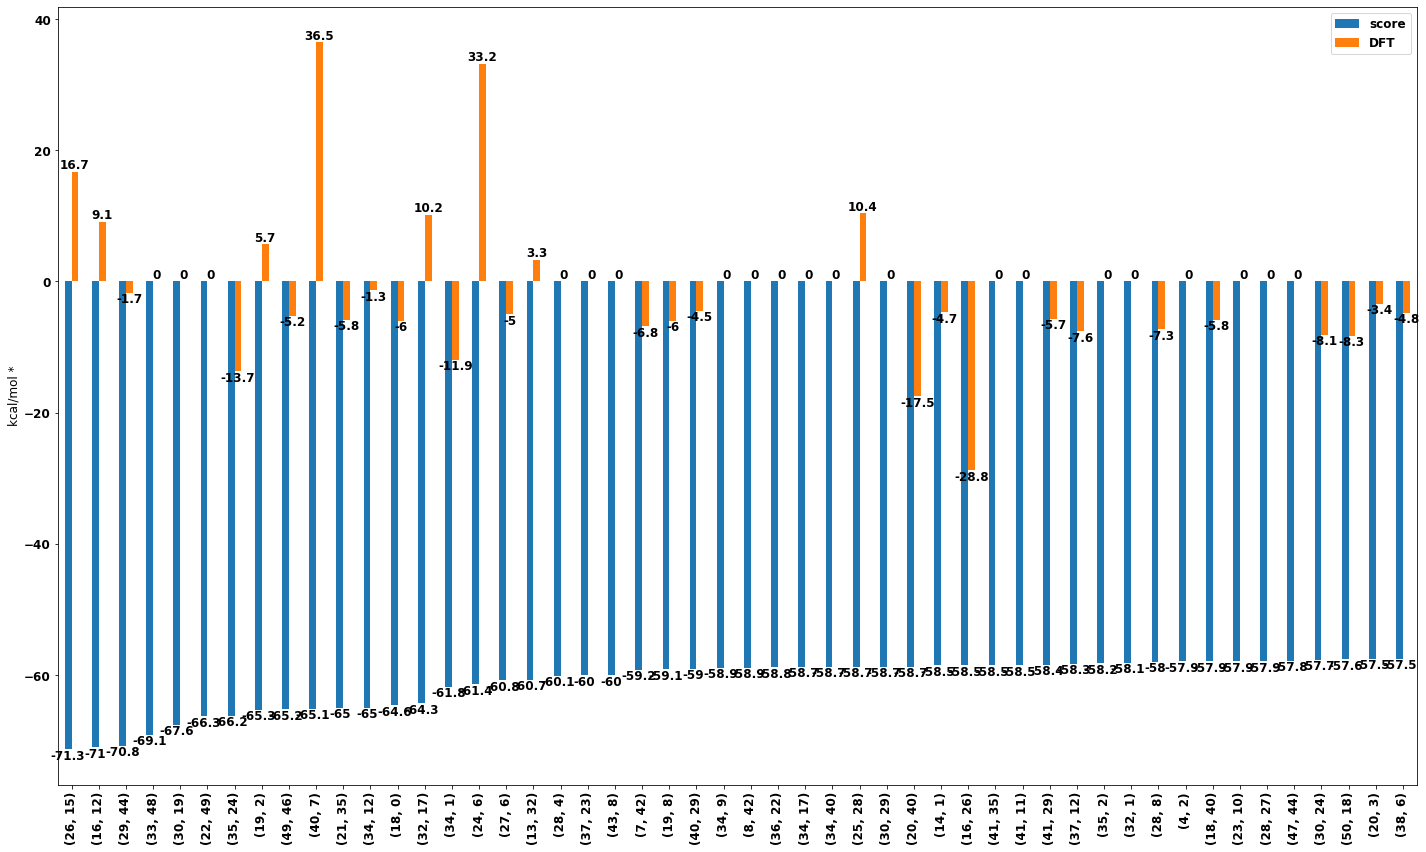

In [10]:
fig, ax = plt.subplots(figsize=(20, 12))

file = logfiles[0]

f1 = sorted(logfiles[0].glob('*[!.csv]'))

# Get the scoring funtion that was used
if sorted(file.glob('*/Mo_NH3+')):
    scoring = 'rdkit_embed_scoring_NH3plustoNH3'
elif sorted(file.glob('*/Mo_N2_NH3')):
    scoring = 'rdkit_embed_scoring'
    print('setting rkdit_embed_scoring')
elif sorted(file.glob('*/Mo_N2')):
    scoring = 'rdkit_embed_scoring_NH3toN2'

print(f'Scoring used: {scoring}')
inds,deltas = funcs[scoring](f1)
print(f'deltas for f1:{deltas}')


gen = Generation(molecules=inds)
df = gen.gen2pd()
df['DFT'] = deltas
df['score'] = df['score'].apply(lambda x: round(x, 1))
df['DFT'] = df['DFT'].apply(lambda x: round(x, 1))
df.sort_values(by=['score'], inplace=True)

# Save DF
#df.to_csv(dataframe_path)
# Scoring function dict
df[['score','DFT',]].plot.bar(ax=ax);
ax.set(ylabel='kcal/mol *',xlabel='')
ax.legend(['score','DFT'])
#ax.set_xticks([f'Molecule {x}' for x in range(5)])
for container in ax.containers:
    ax.bar_label(container)
fig.tight_layout()

#fig.savefig('img.png',dpi=600)

In [10]:
# 200 HARTREE DIFFERENCE"!!!!!

In [11]:
N2 = -6218.396054880547
NH3 = -6165.431811449106

In [12]:
# Test debug auxilliary basis 26,15
delta = (N2 * kcal + reactions_dft_orca_sarcJ_tzp["NH3"]) - (
                        NH3 * kcal + reactions_dft_orca_sarcJ_tzp["N2"]
                    )

In [13]:
delta

16.77778506791219

In [14]:
NH3 = -6001.356992364919
N2 = -6054.384083461080

### Standard comparing all in same plot

In [15]:
logfiles = [dft_base / 'prod_new22_large_0',dft_base/'prod_new22_large_0_long_def2j']
#logfiles = [dft_base / 'prod_new26_2score_large_0',dft_base / 'prod_new26_2score_large_0']

In [16]:
len(f2)

NameError: name 'f2' is not defined

In [ ]:
f2

In [ ]:
f1

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

file = logfiles[0]

f1 = sorted(logfiles[0].glob('*[!.csv]'))
f2 = sorted(logfiles[1].glob('*[!.csv]'))


tmp = []
for elem in f2:
    if any(elem.name in str(x) for x in f1):
        tmp.append(elem)

f2 = tmp
del f2[-4]


# Get the scoring funtion that was used
if sorted(file.glob('*/Mo_NH3+')):
    scoring = 'rdkit_embed_scoring_NH3plustoNH3'
elif sorted(file.glob('*/Mo_N2_NH3')):
    scoring = 'rdkit_embed_scoring'
    print('setting rkdit_embed_scoring')
elif sorted(file.glob('*/Mo_N2')):
    scoring = 'rdkit_embed_scoring_NH3toN2'


inds,deltas = funcs[scoring](f1)
inds2,deltas2 = funcs[scoring](f2)
print(f'deltas for f1:{deltas}')

gen = Generation(molecules=inds)
df = gen.gen2pd()
df['DFT'] = deltas
df['DFT2'] = deltas2
df['score'] = df['score'].apply(lambda x: round(x, 1))
df['DFT'] = df['DFT'].apply(lambda x: round(x, 1))
df['DFT2'] = df['DFT2'].apply(lambda x: round(x, 1))
df.sort_values(by=['score'], inplace=True)

# Save DF
#df.to_csv(dataframe_path)
# Scoring function dict
df[['score','DFT', 'DFT2']].plot.bar(ax=ax);
ax.set(ylabel='kcal/mol *',xlabel='')
ax.legend(['score','DFT (SARC/J)', 'DFT (def2/J)'])
#ax.set_xticks([f'Molecule {x}' for x in range(5)])
for container in ax.containers:
    ax.bar_label(container)
fig.tight_layout()

fig.savefig('img.png',dpi=600)

### 

### One plot for each

In [ ]:
#logfiles = [dft_base/'prod_new24_1score_large_0',dft_base/'prod_new23_1score_large_0',dft_base/'prod_new25_2score_large_0',dft_base/'prod_new12_0',dft_base/'prod_new20_large_0',dft_base/'prod_new19_large_0']

logfiles = [dft_base/'prod_new26_2score_large_0']
num_plots = len(logfiles)

/home/magstr/dft_data/prod_new26_2score_large_0


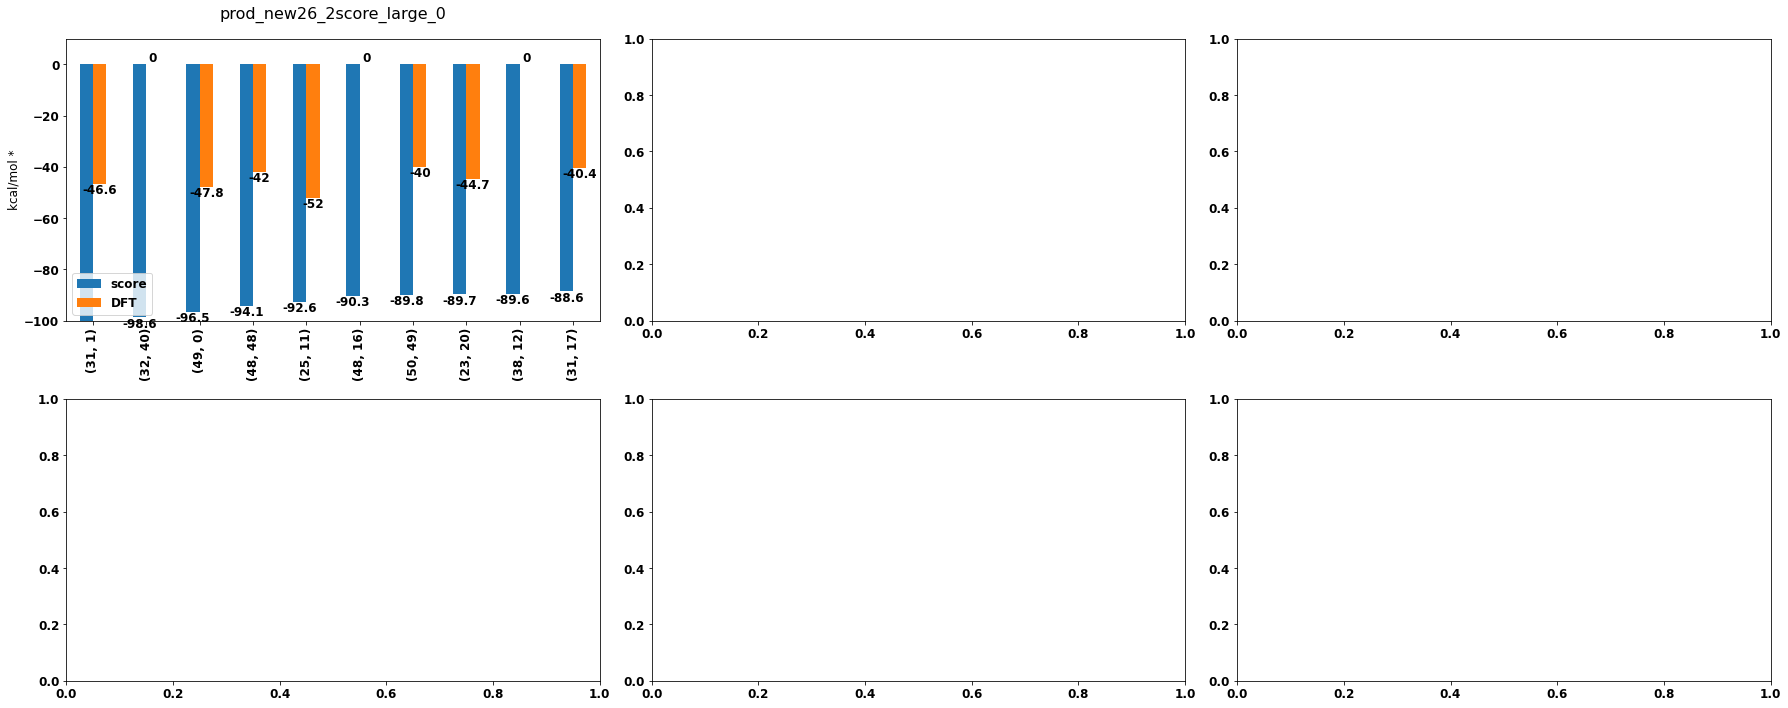

In [15]:
# Init figure
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(25, 10));
ax = ax.flatten()

for i,file in enumerate(logfiles):
    print(file)
    ax_i=ax[i]
    
    # Get the scoring funtion that was used
    if sorted(file.glob('*/Mo_NH3+')):
        scoring = 'rdkit_embed_scoring_NH3plustoNH3'
    elif sorted(file.glob('*/Mo_N2_NH3')):
        scoring = 'rdkit_embed_scoring'
        print('setting rkdit_embed_scoring')
    elif sorted(file.glob('*/Mo_N2')):
        scoring = 'rdkit_embed_scoring_NH3toN2'

        
    f = sorted(file.glob('*[!.csv]'))
    dataframe_path = f[0].parent /'df.csv'
    
    # Delete csv and redo scoring
    #if dataframe_path.is_file():
    #    dataframe_path.unlink()
    
    if dataframe_path.is_file():
        df = pd.read_csv(dataframe_path, index_col=[0,1])
    else:
        print(scoring,f)
        inds,deltas = funcs[scoring](f)
        
        gen = Generation(molecules=inds)
        df = gen.gen2pd()
        df['DFT'] = deltas
        df['score'] = df['score'].apply(lambda x: round(x, 1))
        df['DFT'] = df['DFT'].apply(lambda x: round(x, 1))
        df.sort_values(by=['score'], inplace=True)
        
        # Save DF
        df.to_csv(dataframe_path)
        
    df[['score','DFT']].plot.bar(ax=ax_i);
    ax_i.set(ylabel='kcal/mol *',ylim=(-100,10), xlabel='')
    ax_i.set_title(f[0].parent.name,fontsize = 16, pad=20)
    #ax.set_xticks([f'Molecule {x}' for x in range(5)])
    for container in ax_i.containers:
        ax_i.bar_label(container)
fig.tight_layout()

## Bar and correlation plots

In [13]:
logfiles = [dft_base/'prod_new15_large_0', dft_base/'prod_new16_large_0', dft_base/'prod_new17_large_0', dft_base/'prod_new18_large_0', dft_base/'prod_new19_large_0',\
            dft_base/'prod_new21_large_0', dft_base/'prod_new22_large_0', dft_base/'prod_new23_1score_large_0', dft_base/'prod_new24_1score_large_0',\
            dft_base/'prod_new26_2score_large_0', dft_base/'prod_new27_small_0', dft_base/'prod_new28_small_0']
num_plots = len(logfiles)

In [14]:
# Something is wrong with 20 and 25

/home/magstr/dft_data/prod_new15_large_0
/home/magstr/dft_data/prod_new16_large_0
/home/magstr/dft_data/prod_new17_large_0
/home/magstr/dft_data/prod_new18_large_0
/home/magstr/dft_data/prod_new19_large_0
/home/magstr/dft_data/prod_new21_large_0
/home/magstr/dft_data/prod_new22_large_0
/home/magstr/dft_data/prod_new23_1score_large_0
/home/magstr/dft_data/prod_new24_1score_large_0
/home/magstr/dft_data/prod_new26_2score_large_0
/home/magstr/dft_data/prod_new27_small_0
/home/magstr/dft_data/prod_new28_small_0


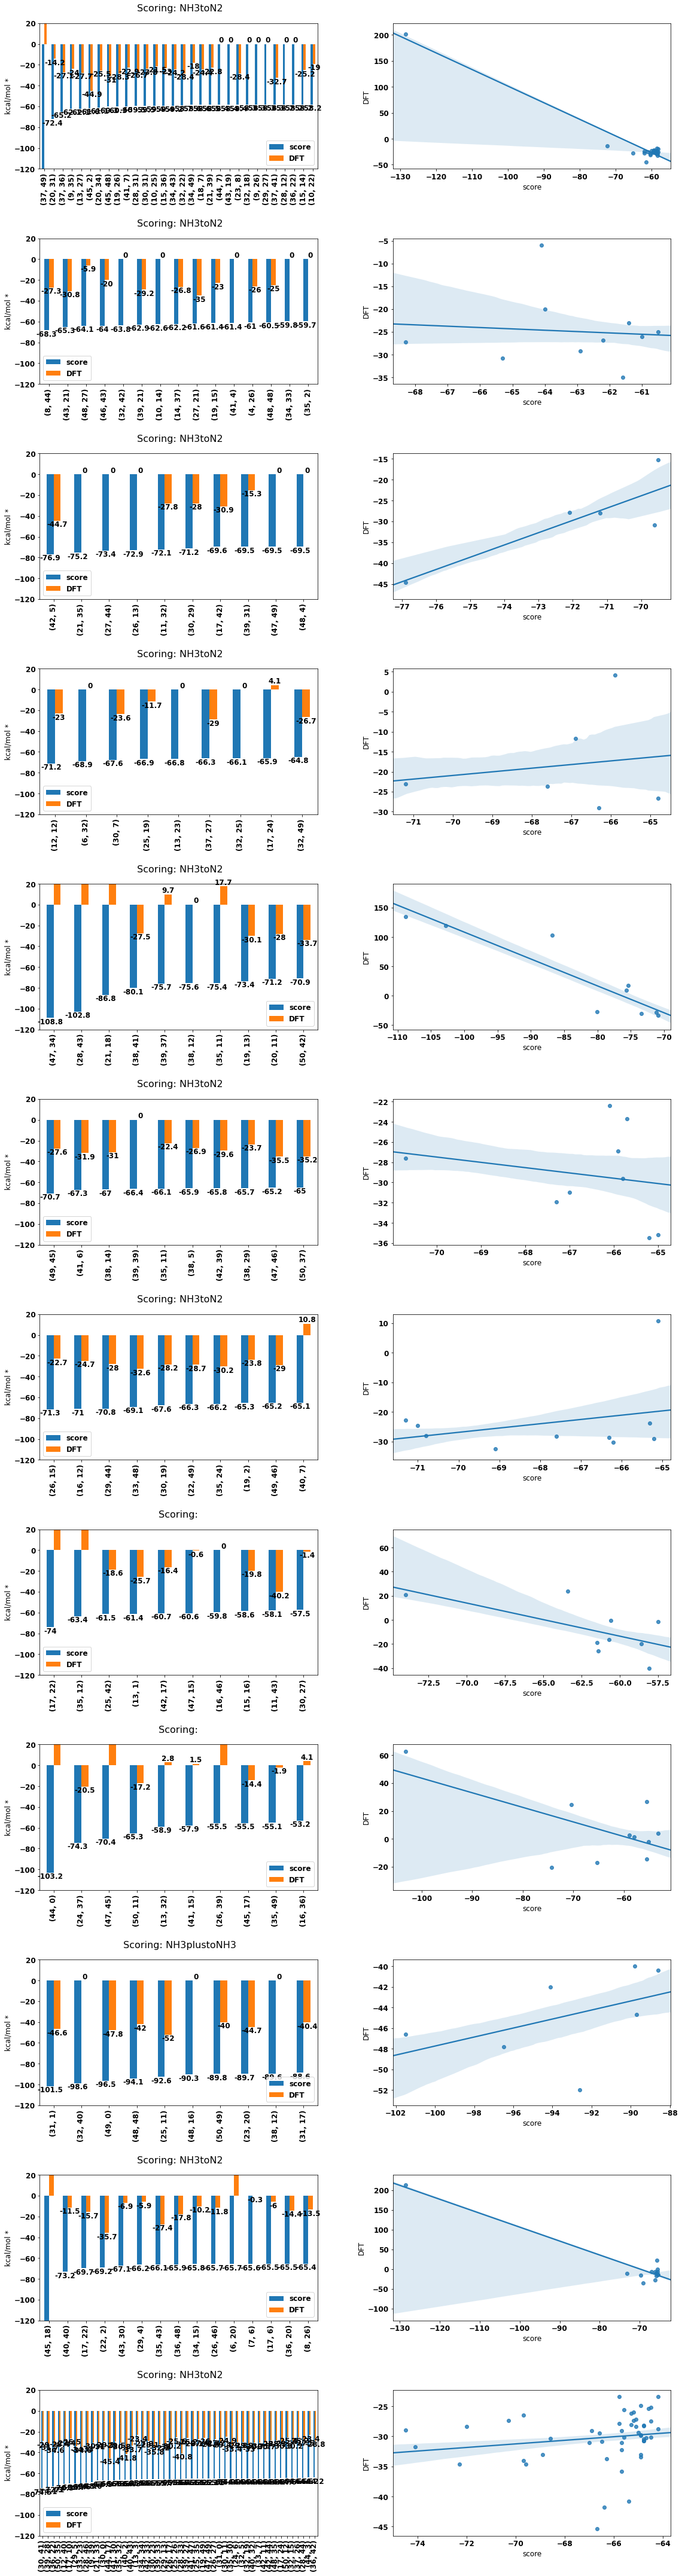

In [11]:
top_list = []


# Init figure
fig, ax = plt.subplots(nrows=num_plots,ncols=2,figsize=(16, 60));

for i,file in enumerate(logfiles):
    print(file)
    
    ax_i = ax[i,0]
    
    # Get the scoring funtion that was used
    if sorted(file.glob('*/Mo_NH3+')):
        scoring = 'rdkit_embed_scoring_NH3plustoNH3'
    elif sorted(file.glob('*/Mo_N2_NH3')):
        scoring = 'rdkit_embed_scoring'
    elif sorted(file.glob('*/Mo_N2')):
        scoring = 'rdkit_embed_scoring_NH3toN2'

        
    f = sorted(file.glob('*[!.csv]'))
    dataframe_path = f[0].parent /'df.csv'
    
    # Delete csv and redo scoring
    #if dataframe_path.is_file():
    #    dataframe_path.unlink()
    
    if dataframe_path.is_file():
        df = pd.read_csv(dataframe_path, index_col=[0,1])
        
    else:
        inds,deltas = funcs[scoring](f)
        
        gen = Generation(molecules=inds)
        df = gen.gen2pd()
        df['DFT'] = deltas
        df['score'] = df['score'].apply(lambda x: round(x, 1))
        df['DFT'] = df['DFT'].apply(lambda x: round(x, 1))
        df.sort_values(by=['score'], inplace=True)
        
        df['smiles'] = [Chem.MolToSmiles(x) for x in df['rdkit_mol'].values]
        df['scoring'] = [scoring]*len(inds)
        
        # Save DF
        df.to_csv(dataframe_path)
        
        # Append good scoring molecules to list
        arr =np.array(deltas)
        # Reference DFT energy for original catalyst for the N2 to 
        arr = arr<-20
        lst = [ind for ind,condition in zip(inds,arr) if condition]
        top_list.extend(lst)
        
    df[['score','DFT']].plot.bar(ax=ax_i);
    ax_i.set(ylabel='kcal/mol *',ylim=(-120,20), xlabel='')
    
    # Folder title: f[0].parent.name
    ax_i.set_title(f' Scoring: {scoring[20:]}',fontsize = 16, pad=20)
    #ax.set_xticks([f'Molecule {x}' for x in range(5)])
    for container in ax_i.containers:
        ax_i.bar_label(container)
        
        
    # Plot corresponding correlation pplot
    sns.regplot(x="score", y="DFT",ci=68,truncate=False,data=df[df['DFT']!=0], ax=ax[i,1]);
        
    
# Magic
fig.tight_layout(h_pad=2, w_pad=5)

#plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)

The large values in the charge scoring function can be attributed to conformational artifacts? Poor xtb optimization? 

## Get the best scoring molecules over different generations and visualize them 

In [14]:
total_df = pd.DataFrame(columns=['score', 'energy', 'sa_score', 'rdkit_mol', 'DFT', 'smiles'])
for i,file in enumerate(logfiles):
    print(file)
    
    # Get the scoring funtion that was used
    if sorted(file.glob('*/Mo_NH3+')):
        scoring = 'rdkit_embed_scoring_NH3plustoNH3'
    elif sorted(file.glob('*/Mo_N2_NH3')):
        scoring = 'rdkit_embed_scoring'
    elif sorted(file.glob('*/Mo_N2')):
        scoring = 'rdkit_embed_scoring_NH3toN2'

        
    f = sorted(file.glob('*[!.csv]'))
    dataframe_path = f[0].parent /'df.csv'
    
    # Delete csv and redo scoring
    #if dataframe_path.is_file():
    #    dataframe_path.unlink()
    
    if dataframe_path.is_file():
        df = pd.read_csv(dataframe_path, index_col=[0,1])
        total_df=pd.concat([total_df,df])

/home/magstr/dft_data/prod_new15_large_0
/home/magstr/dft_data/prod_new16_large_0
/home/magstr/dft_data/prod_new17_large_0
/home/magstr/dft_data/prod_new18_large_0
/home/magstr/dft_data/prod_new19_large_0
/home/magstr/dft_data/prod_new21_large_0
/home/magstr/dft_data/prod_new22_large_0
/home/magstr/dft_data/prod_new23_1score_large_0
/home/magstr/dft_data/prod_new24_1score_large_0
/home/magstr/dft_data/prod_new26_2score_large_0
/home/magstr/dft_data/prod_new27_small_0
/home/magstr/dft_data/prod_new28_small_0


In [15]:
extract = total_df[total_df['DFT']<-20]

In [16]:
final = extract[extract.apply(lambda x: CalcNumRotatableBonds(Chem.MolFromSmiles(x['smiles'])) <= 4, axis=1)]

In [17]:
final

,score,energy,sa_score,rdkit_mol,DFT,smiles,cut_idx,scoring
"(37, 36)",-65.2,-65.238807,1.000000,<rdkit.Chem.rdchem.Mol object at 0x7f5142eb7030>,-27.1,CC(N)CCC1CCC1,8.0,rdkit_embed_scoring_NH3toN2
"(9, 35)",-62.1,-62.113881,1.000000,<rdkit.Chem.rdchem.Mol object at 0x7f5142e59cf0>,-24.0,CNCC(N)c1ccc(F)cc1Cl,5.0,rdkit_embed_scoring_NH3toN2
"(13, 27)",-62.1,-62.081733,1.000000,<rdkit.Chem.rdchem.Mol object at 0x7f5142efc430>,-27.7,CCCCCCN,6.0,rdkit_embed_scoring_NH3toN2
"(20, 34)",-61.1,-61.069443,1.000000,<rdkit.Chem.rdchem.Mol object at 0x7f5142eb7570>,-25.5,CC(N)CCCF,6.0,rdkit_embed_scoring_NH3toN2
"(45, 48)",-60.3,-60.316929,1.000000,<rdkit.Chem.rdchem.Mol object at 0x7f5142e20df0>,-31.0,CC(N)Cc1ccc(Cc2ccccc2)cc1,16.0,rdkit_embed_scoring_NH3toN2
...,...,...,...,...,...,...,...,...
"(42, 44)",-64.8,-64.797395,1.000000,<rdkit.Chem.rdchem.Mol object at 0x7f5140cecdb0>,-28.2,CCNCCC(C)(C)N,5.0,rdkit_embed_scoring_NH3toN2
"(48, 35)",-64.8,-67.235446,0.964209,<rdkit.Chem.rdchem.Mol object at 0x7f5140cb3b70>,-28.3,CCCCN1CCCC(N)(C2CCC2)C1,5.0,rdkit_embed_scoring_NH3toN2
"(17, 24)",-64.7,-64.677346,1.000000,<rdkit.Chem.rdchem.Mol object at 0x7f5140df99b0>,-30.3,CCCCC(C)(C)N,5.0,rdkit_embed_scoring_NH3toN2
"(50, 12)",-64.6,-64.579092,1.000000,<rdkit.Chem.rdchem.Mol object at 0x7f5140cb3bb0>,-25.4,CCCN(C)CC(C)(C)N,4.0,rdkit_embed_scoring_NH3toN2


In [141]:
mols = [Chem.MolFromSmiles(x) for x in final['smiles']]
idx = range(0,len(final))
score = [score for score in final['scoring']]

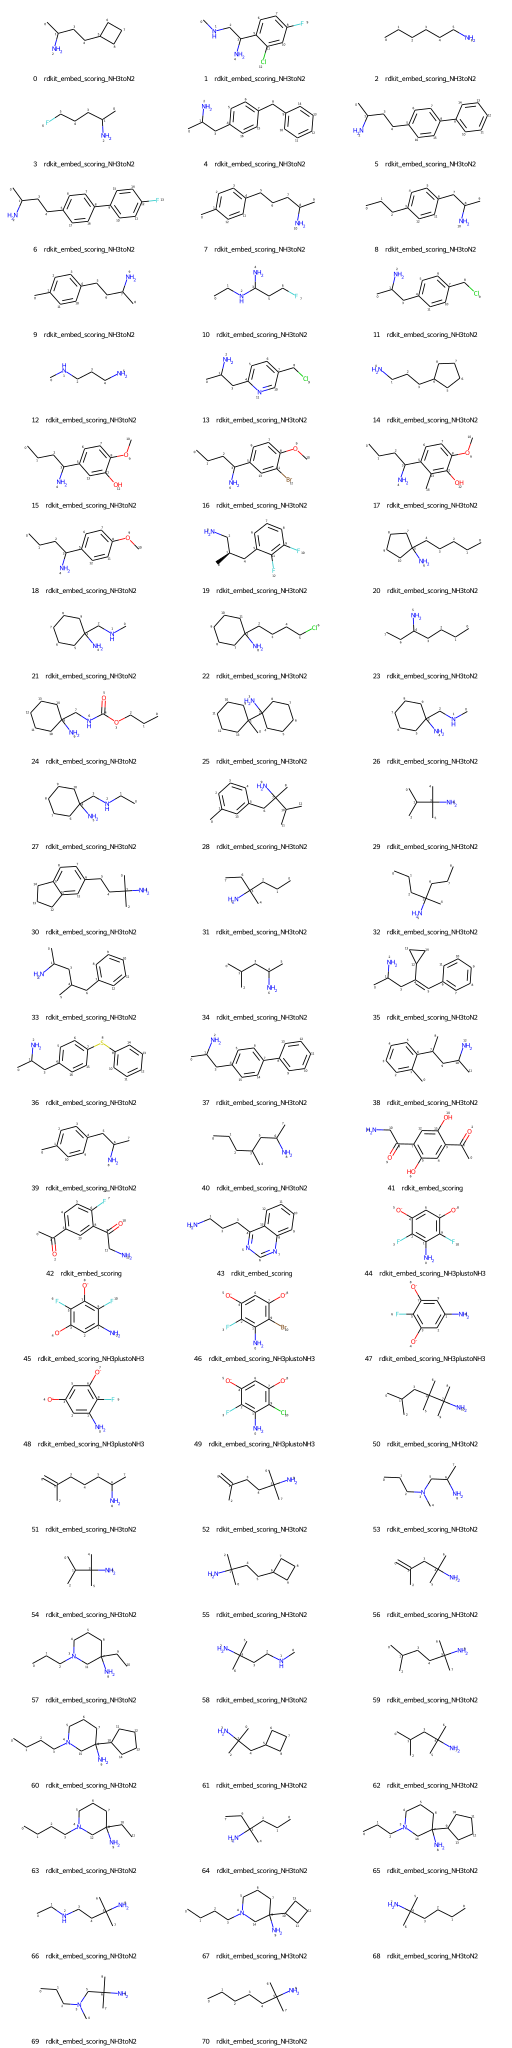

In [145]:
img  = Draw.MolsToGridImage(mols,molsPerRow=3,maxMols=100,legends=[f'{x}    {score}' for x, score in zip(idx,score)], highlightAtomLists=cut_idx,subImgSize=(400,200), useSVG=True)
img

In [21]:
with open('mol.svg','w') as f:
    f.write(img.data)64, 6, 32

In [75]:
#img.save('candidates', format='png')

In [82]:
# NH3 -> N2
0, 65

# NH3 -> N2_NH3
42, 43

# NH3plus to NH3
47, 49
    

(55, 54)

In [18]:
final = final.iloc[[0, 65, 42, 43, 47, 49]]

In [19]:
final.to_csv('first_conformers.csv')